# CountingPeople

## Static statistics 
### Description

The following code generates some statistics used to annalyse our system.

### Requisites

    - Python 3.6
    - Pandas
    - Matplotlib
    - numpy
    - Ipython


In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Functions

    - read_csv: read the csv and parse it to dataFrame

In [9]:
def read_csv(file):
    csv = pd.read_csv(file)
    csv['time'] = pd.to_datetime(csv['time'], format='%Y/%m/%d-%H:%M:%S')
    csv = csv.set_index(pd.DatetimeIndex(csv['time']))
    csv = csv.sort_values(['time'], ascending=[True])
    return csv


    - consult_api: call to the API, get the csv and parse it to dataFrame

In [10]:
def consult_api():
    url = "http://localhost:3000/macs"
    myReq = requests.get(url, headers={'Accept': 'text/csv'})
    if myReq.ok:
        return read_csv(io.StringIO(myReq.content.decode('utf-8')))

    - mac_occurs: plot the mac occurs along the time

In [11]:
def mac_occurs(df, show):
    g = df.groupby(["mac", "time"], as_index=False)
    d= g.size()
    plt.axes().axes.set_xticklabels([])
    plt.title('Occurs per mac')
    plt.xlabel("MACs")
    plt.ylabel("Occurs")
    plt.tight_layout()
    ax = d.plot(x='mac', y=d, kind='bar')
    ax.set_xticklabels([])
    plt.savefig('mac_occurs.pdf', bbox_inches="tight")
    
    if show is True:
        plt.show()
    
    plt.gcf().clear()

    - origin_activity: plot all the activity on the system.

In [12]:
def origin_activity(df, show):
    g = df.groupby(pd.TimeGrouper(freq='45s')).size()
    g.plot(x='time', y=g, kind='bar')
    plt.title('Origin activity on the system')
    plt.xlabel("Time")
    plt.ylabel("Origin")
    plt.tight_layout()
    plt.savefig("origin_activity.pdf", bbox_inches="tight")
    
    if show is True:
        plt.show()
    
    plt.gcf().clear()

    - mac_activity: plots the activity each mac along the time 

In [13]:
"""
It should be wrong but gives the same result that mac_activity_good
"""
def mac_activity_bad(df, show):
    df = df.drop(['type', 'ID', 'device'], axis=1)
    g = df.groupby([
        pd.TimeGrouper(freq='45s')], as_index=True)

    df = pd.DataFrame(columns=['time', 'macs'])
    for name, group in g:
        df.loc[len(df)] = [name, len(group.groupby(['mac']))]

    df.plot(x='time', y='macs', kind='bar',
            title='Mac activity on the system', legend=False)
    plt.title('Activity on the system')
    plt.xlabel("Time")
    plt.ylabel("Activity")
    plt.tight_layout()
    plt.savefig("mac_activity_bad.pdf", bbox_inches="tight")
    
    if show is True:
        plt.show()
    
    plt.gcf().clear()

In [14]:
def mac_activty_good(df, show):
    csv_1 = df.drop(['type', 'ID', 'device'], axis=1)
    csv_1 = csv_1.set_index(pd.DatetimeIndex(csv_1['time']))
    group_by_mac_in_time = csv_1.groupby(['mac'], as_index=False).first()
    group_by_mac_in_time = group_by_mac_in_time.set_index(
        pd.DatetimeIndex(group_by_mac_in_time['time']))
    group_by_mac_in_time = group_by_mac_in_time.groupby(
        [pd.TimeGrouper(freq='45s')], as_index=False).size()

    plt.title('Activity on the system')
    plt.xlabel("Time")
    plt.ylabel("MAC")
    group_by_mac_in_time.plot(kind='bar')
    plt.savefig("mac_activity_good.pdf", bbox_inches="tight")
    plt.tight_layout()
    
    if show is True:
        plt.show()
    
    plt.gcf().clear()

    - mac_system: Plot the acumulated number of macs in the system

In [15]:
def mac_system(df, show):
    csv_1 = df.drop(['type', 'ID', 'device'], axis=1)
    csv_1 = csv_1.set_index(pd.DatetimeIndex(csv_1['time']))
    group_by_mac_in_time = csv_1.groupby(['mac'], as_index=False).first()
    group_by_mac_in_time = group_by_mac_in_time.set_index(
        pd.DatetimeIndex(group_by_mac_in_time['time']))
    group_by_mac_in_time = group_by_mac_in_time.groupby(
        [pd.TimeGrouper(freq='45s')], as_index=False).size().cumsum()

    plt.title('Mac on the system')
    plt.xlabel("Time")
    plt.ylabel("Nº Macs")
    group_by_mac_in_time.plot()
    plt.savefig("mac_system.pdf", bbox_inches="tight")
    
    if show is True:
        plt.show()
    plt.gcf().clear()

    - T_burst: Plot the time between burst for each mac, and plot the average time between burst. 

In [16]:
def T_burst(df, show):
    df = df.drop(['ID', 'device'], axis=1)
    df = df[~df['type'].isin(['random'])]
    df = df.groupby(['mac'], as_index=True)
    df_t = pd.DataFrame(columns=['mac', 'average'])

    for index, mac in df:
        t_average = 0
        t_previous = datetime.now()

        # MACs with only one occurrency are discarted
        if(len(mac['time'])) != 1:
            i = 0
            for idx, time in enumerate(mac['time']):
                if idx == 0:
                    t_previous = time

                else:
                    diff = (time - t_previous).total_seconds()
                    # macs which are received in the same seconds are discarted
                    if diff != float(0):
                        t_average += diff
                        t_previous = time
                        i += 1

                # average
                if idx is len(mac) - 1:
                    if i == 0:
                        i = 1
                    t_average = t_average / i
                    df_t.loc[len(df_t)] = [index, t_average]

    # macs with average equal to 0 are discarted => consecutive emits by the same device
    df_t = df_t[~df_t['average'].isin([0.0])]
    
    # Plot burts time for each mac
    ax = df_t.plot(x=df_t['mac'])
    ax.set_xticklabels([])
    plt.title('Time MAC burst')
    plt.xlabel("Mac")
    plt.ylabel("Burst")
    plt.savefig("time_mac_burst.pdf", bbox_inches="tight")
    
    if show is True:
        plt.show()
    plt.gcf().clear()
    
    ###########       PLOT DISTRIBUTION  ########
    fig, axes = plt.subplots(nrows=2, ncols=1)
    df_t.plot(y='average', kind='hist', rot=0, ax=axes[0], legend=False)
    df_t.plot(y='average', kind='kde', ax=axes[1], legend=False)
    axes[0].set_xlim(xmin=0, xmax=500)
    axes[1].set_xlim(xmin=0, xmax=500)
    plt.xlabel("Time")
    plt.savefig("time_burst.pdf", bbox_inches="tight")
    
    if show is True:
        plt.show()
    plt.gcf().clear()

    ###########        PLOT DISTRIBUTION grouped ########
    # macs are agrupated in 10 groups
    bins = np.linspace(0, df_t.average.max(), 10)
    df_t['category'] = pd.cut(df_t['average'], bins)
    count = df_t.groupby(['category']).size()

    fig, axes = plt.subplots(nrows=2, ncols=1)
    count.plot(kind='hist', ax=axes[0])
    count.plot(kind='kde', ax=axes[1])
    axes[0].set_xlim(xmin=0)
    axes[1].set_xlim(xmin=0)
    plt.xlabel("Time")
    plt.savefig("time_categorize_burst.pdf", bbox_inches="tight")
    
    if show is True:
        plt.show()
    plt.gcf().clear()

### Example

Main program example with results

In [17]:
#df = consult_api()
df = read_csv('Captura_Peritos.csv')

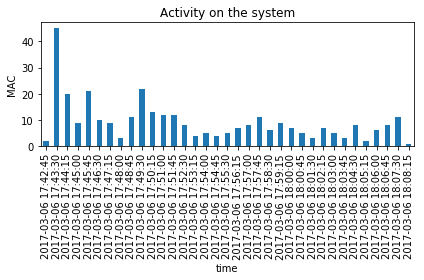

In [18]:
mac_activty_good(df, True)

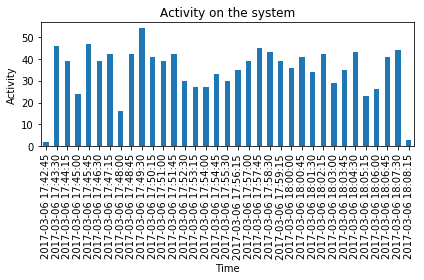

In [19]:
mac_activity_bad(df, True)

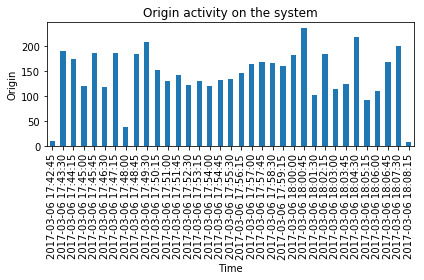

In [20]:
origin_activity(df, True)

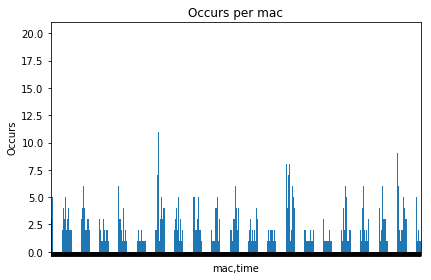

In [21]:
mac_occurs(df, True)

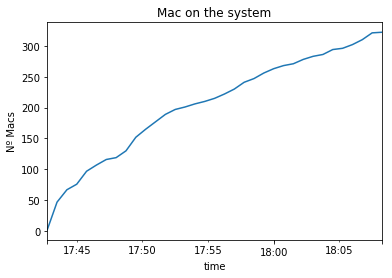

In [22]:
mac_system(df, True)

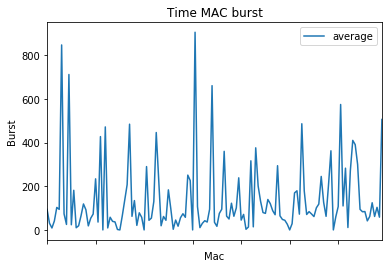

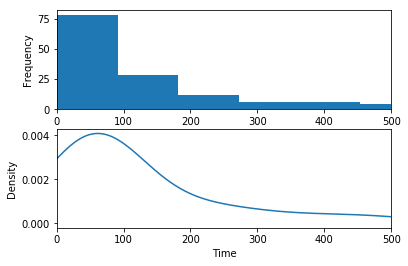

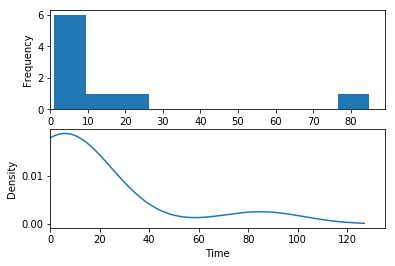

In [23]:
T_burst(df, True)